<a href="https://colab.research.google.com/github/RayirthSoni/Aspect-Based-Sentiment-Analysis-for-Product-Reviews/blob/main/ABSA_for_product_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Mounted at /content/drive


# All Downloads

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 4.9 MB/s eta 0:00:00


# Importing Files in Directory

In [ ]:
!cp /content/drive/MyDrive/SNA\ Project/stop_words.py /content
!cp /content/drive/MyDrive/SNA\ Project/wn_affect.py /content

# Importing all libraries

In [ ]:
import json
import pandas as pd
import numpy as np
import re
import os
import sys
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stop_words import stop_words_list
from wn_affect import wn_affect
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gzip
import tensorflow as tf
tf.test.gpu_device_name()
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


# File Names

In [ ]:
# All Paths

# dataset path
dataset_path =  r"/content/drive/MyDrive/SNA Project/Dataset/cell_phones_and_accessories.json"

# Save DataFrame
df_path = r"/content/drive/MyDrive/SNA Project/Dataset/processed_dataframe.json"

# sample image path
sample_img_path = r"/content/drive/MyDrive/SNA Project/sample_images_model"

# sample model path
sample_model_path = r"/content/drive/MyDrive/SNA Project/sample_images_model"

# Get Dataframe

In [ ]:
sample_df = pd.read_json(dataset_path,lines=True)
sample_df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
...,...,...,...,...,...,...,...,...,...
194434,A1YMNTFLNDYQ1F,B00LORXVUE,eyeused2loveher,"[0, 0]",Works great just like my original one. I reall...,5,This works just perfect!,1405900800,"07 21, 2014"
194435,A15TX8B2L8B20S,B00LORXVUE,Jon Davidson,"[0, 0]",Great product. Great packaging. High quality a...,5,Great replacement cable. Apple certified,1405900800,"07 21, 2014"
194436,A3JI7QRZO1QG8X,B00LORXVUE,Joyce M. Davidson,"[0, 0]","This is a great cable, just as good as the mor...",5,Real quality,1405900800,"07 21, 2014"
194437,A1NHB2VC68YQNM,B00LORXVUE,Nurse Farrugia,"[0, 0]",I really like it becasue it works well with my...,5,I really like it becasue it works well with my...,1405814400,"07 20, 2014"


In [ ]:
df_original = sample_df.copy()
df_original.columns
df_original.drop(['reviewerID','asin','reviewerName','helpful','overall','summary','unixReviewTime','reviewTime'],inplace=True,axis=1)
df_original

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

,reviewText
0,They look good and stick good! I just don't li...
1,These stickers work like the review says they ...
2,These are awesome and make my phone look so st...
3,Item arrived in great time and was in perfect ...
4,"awesome! stays on, and looks great. can be use..."
...,...
194434,Works great just like my original one. I reall...
194435,Great product. Great packaging. High quality a...
194436,"This is a great cable, just as good as the mor..."
194437,I really like it becasue it works well with my...


## Preprocessing

In [ ]:
# cast text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string
def preprocessing(review):
    review = review.lower()
    review = re.sub(r"'",'',review)
    review = re.sub('[^\w\s]',' ',review)
    review = re.sub(" \d+", " ",review)
    review = re.sub(" +",' ',review)
    review = review.strip()
    return review

In [ ]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()
def get_sentiment_and_score(preprocessed_review):
    sent_score = None
    sent_label = None
    sentiment_score = analyser.polarity_scores(preprocessed_review)
    if sentiment_score['compound'] >= 0.05:
        sent_score = sentiment_score['compound']
        sent_label = 'Positive'
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sent_score = sentiment_score['compound']
        sent_label = 'Neutral'
    elif sentiment_score['compound'] <= -0.05:
        sent_score = sentiment_score['compound']
        sent_label = 'Negative'
    return sent_label,sent_score

In [ ]:
# Preprocess the review
df_original['preprocessed review'] = df_original['reviewText'].apply(preprocessing)
df_original.head()

,reviewText,preprocessed review
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...
1,These stickers work like the review says they ...,these stickers work like the review says they ...
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...


## tokenise

In [ ]:
# tokenise prepreprocesed review
df_original['tokenise'] = df_original.apply(lambda x: nltk.word_tokenize(x["preprocessed review"]), axis=1)
df_original.head()

,reviewText,preprocessed review,tokenise
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,"[they, look, good, and, stick, good, i, just, ..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,"[these, stickers, work, like, the, review, say..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,"[these, are, awesome, and, make, my, phone, lo..."
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,"[item, arrived, in, great, time, and, was, in,..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,"[awesome, stays, on, and, looks, great, can, b..."


In [ ]:
# Get Sentiment anf Sentiment Score for Reviews
df_original[['sentiment','sentiment score']] = df_original['preprocessed review'].apply(get_sentiment_and_score).apply(pd.Series)
df_original.head()

,reviewText,preprocessed review,tokenise,sentiment,sentiment score
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,"[they, look, good, and, stick, good, i, just, ...",Positive,0.4922
1,These stickers work like the review says they ...,these stickers work like the review says they ...,"[these, stickers, work, like, the, review, say...",Positive,0.9136
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,"[these, are, awesome, and, make, my, phone, lo...",Positive,0.8481
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,"[item, arrived, in, great, time, and, was, in,...",Positive,0.9584
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,"[awesome, stays, on, and, looks, great, can, b...",Positive,0.8957


## remove stopwords

In [ ]:
# initiate stopwords from nltk
stop_words = stopwords.words('english')

# add additional missing terms
stop_words.extend(stop_words_list)

# remove stopwords
df_original['remove_stopwords'] = df_original['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])

df_original.head()

,reviewText,preprocessed review,tokenise,sentiment,sentiment score,remove_stopwords
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,"[they, look, good, and, stick, good, i, just, ...",Positive,0.4922,"[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,"[these, stickers, work, like, the, review, say...",Positive,0.9136,"[stickers, work, review, stick, stay, phone, s..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,"[these, are, awesome, and, make, my, phone, lo...",Positive,0.8481,"[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,"[item, arrived, in, great, time, and, was, in,...",Positive,0.9584,"[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,"[awesome, stays, on, and, looks, great, can, b...",Positive,0.8957,"[awesome, stays, multiple, apple, products, na..."


## lemmatise

In [ ]:
# initiate nltk lemmatiser
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words
df_original['lemmatise'] = df_original['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

df_original.head()

,reviewText,preprocessed review,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,"[they, look, good, and, stick, good, i, just, ...",Positive,0.4922,"[good, stick, good, rounded, shape, bumping, s...","[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,"[these, stickers, work, like, the, review, say...",Positive,0.9136,"[stickers, work, review, stick, stay, phone, s...","[sticker, work, review, stick, stay, phone, su..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,"[these, are, awesome, and, make, my, phone, lo...",Positive,0.8481,"[awesome, phone, stylish, year, year, quality]","[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,"[item, arrived, in, great, time, and, was, in,...",Positive,0.9584,"[item, arrived, time, perfect, condition, orde...","[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,"[awesome, stays, on, and, looks, great, can, b...",Positive,0.8957,"[awesome, stays, multiple, apple, products, na...","[awesome, stay, multiple, apple, product, nail..."


## save dataframe

### datatypes before saving

In [ ]:
print(df_original.info())
print(type(df_original.loc[0,'reviewText']))
print(type(df_original.loc[0,'preprocessed review']))
print(type(df_original.loc[0,'sentiment']))
print(type(df_original.loc[0,'sentiment score']))
print(type(df_original.loc[0,'tokenise']))
print(type(df_original.loc[0,'remove_stopwords']))
print(type(df_original.loc[0,'lemmatise']))
df_original.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194439 entries, 0 to 194438
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   reviewText           194439 non-null  object 
 1   preprocessed review  194439 non-null  object 
 2   tokenise             194439 non-null  object 
 3   sentiment            194439 non-null  object 
 4   sentiment score      194439 non-null  float64
 5   remove_stopwords     194439 non-null  object 
 6   lemmatise            194439 non-null  object 
dtypes: float64(1), object(6)
memory usage: 10.4+ MB
None
<class 'str'>
<class 'str'>
<class 'str'>
<class 'numpy.float64'>
<class 'list'>
<class 'list'>
<class 'list'>


,reviewText,preprocessed review,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,"[they, look, good, and, stick, good, i, just, ...",Positive,0.4922,"[good, stick, good, rounded, shape, bumping, s...","[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,"[these, stickers, work, like, the, review, say...",Positive,0.9136,"[stickers, work, review, stick, stay, phone, s...","[sticker, work, review, stick, stay, phone, su..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,"[these, are, awesome, and, make, my, phone, lo...",Positive,0.8481,"[awesome, phone, stylish, year, year, quality]","[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,"[item, arrived, in, great, time, and, was, in,...",Positive,0.9584,"[item, arrived, time, perfect, condition, orde...","[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,"[awesome, stays, on, and, looks, great, can, b...",Positive,0.8957,"[awesome, stays, multiple, apple, products, na...","[awesome, stay, multiple, apple, product, nail..."


### save dataframe in json format

In [ ]:
df_original.to_json(df_path)

## load dataframe

In [ ]:
df_original2 = pd.read_json(df_path)
df_original2

,reviewText,summary,preprocessed review,preprocessed summary,tokenise,sentiment,sentiment score,summary sentiment,remove_stopwords,lemmatise
0,They look good and stick good! I just don't li...,Looks Good,they look good and stick good i just dont like...,looks good,"[they, look, good, and, stick, good, i, just, ...",Positive,0.4922,Positive,"[good, stick, good, rounded, shape, bumping, s...","[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,Really great product.,these stickers work like the review says they ...,really great product,"[these, stickers, work, like, the, review, say...",Positive,0.9136,Positive,"[stickers, work, review, stick, stay, phone, s...","[sticker, work, review, stick, stay, phone, su..."
2,These are awesome and make my phone look so st...,LOVE LOVE LOVE,these are awesome and make my phone look so st...,love love love,"[these, are, awesome, and, make, my, phone, lo...",Positive,0.8481,Positive,"[awesome, phone, stylish, year, year, quality]","[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,Cute!,item arrived in great time and was in perfect ...,cute,"[item, arrived, in, great, time, and, was, in,...",Positive,0.9584,Positive,"[item, arrived, time, perfect, condition, orde...","[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",leopard home button sticker for iphone 4s,awesome stays on and looks great can be used o...,leopard home button sticker for iphone s,"[awesome, stays, on, and, looks, great, can, b...",Positive,0.8957,Neutral,"[awesome, stays, multiple, apple, products, na...","[awesome, stay, multiple, apple, product, nail..."
...,...,...,...,...,...,...,...,...,...,...
194434,Works great just like my original one. I reall...,This works just perfect!,works great just like my original one i really...,this works just perfect,"[works, great, just, like, my, original, one, ...",Positive,0.9356,Positive,"[works, original, extras, car, house, price]","[work, original, extra, car, house, price]"
194435,Great product. Great packaging. High quality a...,Great replacement cable. Apple certified,great product great packaging high quality and...,great replacement cable apple certified,"[great, product, great, packaging, high, quali...",Positive,0.9230,Positive,"[product, packaging, high, quality, apple, cer...","[product, packaging, high, quality, apple, cer..."
194436,"This is a great cable, just as good as the mor...",Real quality,this is a great cable just as good as the more...,real quality,"[this, is, a, great, cable, just, as, good, as...",Positive,0.9862,Neutral,"[cable, good, expensive, apple, husband, daugh...","[cable, good, expensive, apple, husband, daugh..."
194437,I really like it becasue it works well with my...,I really like it becasue it works well with my...,i really like it becasue it works well with my...,i really like it becasue it works well with my...,"[i, really, like, it, becasue, it, works, well...",Positive,0.5984,Positive,"[becasue, works, life, proof, case, remove, ca...","[becasue, work, life, proof, case, remove, cas..."


### datatypes after loading

In [ ]:
print(df_original2.info())
print(type(df_original2.loc[0,'reviewText']))
print(type(df_original2.loc[0,'preprocessed review']))
print(type(df_original2.loc[0,'sentiment']))
print(type(df_original2.loc[0,'sentiment score']))
print(type(df_original2.loc[0,'tokenise']))
print(type(df_original2.loc[0,'remove_stopwords']))
print(type(df_original2.loc[0,'lemmatise']))
df_original2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194439 entries, 0 to 194438
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   reviewText           194439 non-null  object 
 1   preprocessed review  194439 non-null  object 
 2   tokenise             194439 non-null  object 
 3   sentiment            194439 non-null  object 
 4   sentiment score      194439 non-null  float64
 5   remove_stopwords     194439 non-null  object 
 6   lemmatise            194439 non-null  object 
dtypes: float64(1), object(6)
memory usage: 11.9+ MB
None
<class 'str'>
<class 'str'>
<class 'str'>
<class 'numpy.float64'>
<class 'list'>
<class 'list'>
<class 'list'>


,reviewText,preprocessed review,tokenise,sentiment,sentiment score,remove_stopwords,lemmatise
0,They look good and stick good! I just don't li...,they look good and stick good i just dont like...,"[they, look, good, and, stick, good, i, just, ...",Positive,0.4922,"[good, stick, good, rounded, shape, bumping, s...","[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,these stickers work like the review says they ...,"[these, stickers, work, like, the, review, say...",Positive,0.9136,"[stickers, work, review, stick, stay, phone, s...","[sticker, work, review, stick, stay, phone, su..."
2,These are awesome and make my phone look so st...,these are awesome and make my phone look so st...,"[these, are, awesome, and, make, my, phone, lo...",Positive,0.8481,"[awesome, phone, stylish, year, year, quality]","[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,item arrived in great time and was in perfect ...,"[item, arrived, in, great, time, and, was, in,...",Positive,0.9584,"[item, arrived, time, perfect, condition, orde...","[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",awesome stays on and looks great can be used o...,"[awesome, stays, on, and, looks, great, can, b...",Positive,0.8957,"[awesome, stays, multiple, apple, products, na...","[awesome, stay, multiple, apple, product, nail..."


# LDA Model for topics

In [ ]:
# initialise the count vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
print(vectorizer)
print(vectorizer.dtype)
                            
# join the processed data to be vectorised
vectors = []

for index, row in df_original.iterrows():
    vectors.append(", ".join(row['lemmatise']))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)
print(vectorised.dtype)

CountVectorizer(ngram_range=(2, 2))
<class 'numpy.int64'>
  (0, 723168)	1
  (0, 1631906)	1
  (0, 722755)	1
  (0, 1446046)	1
  (0, 1509740)	1
  (0, 210768)	1
  (0, 1539762)	1
  (0, 1262593)	1
  (0, 884560)	1
  (0, 218683)	1
  (1, 1633449)	1
  (1, 1895513)	1
  (1, 1429993)	1
  (1, 1632496)	1
  (1, 1627410)	1
  (1, 1218556)	1
  (1, 1667247)	1
  (1, 1656357)	1
  (1, 1511030)	1
  (2, 103160)	1
  (2, 1218480)	1
  (2, 1656493)	1
  (2, 1917605)	1
  (2, 1916904)	1
  (3, 889176)	1
  :	:
  (194437, 1315151)	1
  (194437, 250693)	1
  (194437, 952053)	1
  (194437, 133773)	1
  (194438, 1894784)	1
  (194438, 282091)	1
  (194438, 1892389)	1
  (194438, 1250038)	1
  (194438, 1306221)	1
  (194438, 987867)	1
  (194438, 1439441)	1
  (194438, 888620)	1
  (194438, 939917)	1
  (194438, 1217919)	1
  (194438, 1778965)	1
  (194438, 381579)	1
  (194438, 382346)	1
  (194438, 1540299)	1
  (194438, 1212422)	1
  (194438, 485376)	1
  (194438, 382410)	1
  (194438, 1856973)	1
  (194438, 1063474)	1
  (194438, 218859)	1
  

## save vectorizer and vectorised

In [ ]:
topic_vectorizer_path = os.path.join(sample_model_path,"topic_vectorizer")
topic_vectorised_path = os.path.join(sample_model_path,"topic_vectorised")
print(topic_vectorizer_path)
print(topic_vectorised_path)

/content/drive/MyDrive/SNA Project/sample_images_model/topic_vectorizer
/content/drive/MyDrive/SNA Project/sample_images_model/topic_vectorised


In [ ]:
# Save vectorizer and vectorised
with open(topic_vectorizer_path,'wb') as f:
    pickle.dump(vectorizer,f)

with open(topic_vectorised_path,'wb') as f:
    pickle.dump(vectorised,f)

## load vectorizer and vectorised

In [ ]:
# Load vectorizer and vectorised
with open(topic_vectorizer_path, 'rb') as f:
    vectorizer = pickle.load(f)

with open(topic_vectorised_path, 'rb') as f:
    vectorised = pickle.load(f)

In [ ]:
print(vectorizer.dtype)
print(vectorised.dtype)
print(vectorizer)
print(vectorised)

## model for identifying topics

In [ ]:
# initisalise LDA Model
# n_components = number of topics
# n_jobs = -1 use all available cpu
lda_model = LatentDirichletAllocation(n_components = 5, evaluate_every = -1, n_jobs = -1)
lda_output = lda_model.fit_transform(vectorised)

In [ ]:
# Prinitng all topic names
keywords = np.array(vectorizer.get_feature_names_out())

topic_keywords = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:20]
    topic_keywords.append(keywords.take(top_keyword_locs))

for i in topic_keywords:
    print(i)

['screen protector' 'sound quality' 'cell phone' 'battery life'
 'car charger' 'usb port' 'bluetooth headset' 'hold phone' 'charge phone'
 'highly recommend' 'ear bud' 'samsung galaxy' 'good price' 'wall charger'
 'belt clip' 'customer service' 'long time' 'definitely recommend'
 'easy install' 'case phone']
['screen protector' 'phone case' 'case fit' 'highly recommend'
 'case phone' 'samsung galaxy' 'case case' 'fit perfectly' 'case iphone'
 'battery life' 'fit phone' 'good quality' 'iphone case' 'protect phone'
 'galaxy s3' 'sound quality' 'add bulk' 'protects phone' 'cell phone'
 'easy install']
['screen protector' 'fit phone' 'phone case' 'samsung galaxy'
 'battery life' 'cell phone' 'sound quality' 'case phone' 'case fit'
 'fit perfectly' 'dropped phone' 'protects phone' 'galaxy note'
 'galaxy s4' 'customer service' 'keep phone' 'galaxy s3' 'case case'
 'phone time' 'phone perfectly']
['battery life' 'micro usb' 'car charger' 'usb cable' 'samsung galaxy'
 'power bank' 'usb port' '

## paths for saving and loading lda model and output

In [ ]:
lda_model_path = os.path.join(sample_model_path,"topic_lda_model")
lda_output_path = os.path.join(sample_model_path,"topic_lda_output")
print(lda_model_path)
print(lda_output_path)

/content/drive/MyDrive/SNA Project/sample_images_model/topic_lda_model
/content/drive/MyDrive/SNA Project/sample_images_model/topic_lda_output


### save lda model and lda output

In [ ]:
# This is for saving lda model after training
with open(lda_model_path,'wb') as f:
    pickle.dump(lda_model,f)

# This is for saving lda output after training
with open(lda_output_path,'wb') as f:
    pickle.dump(lda_output,f)

### load lda model and lda output

In [ ]:
# This is for loading model another runtime
with open(lda_model_path, 'rb') as f:
    lda_model = pickle.load(f)

# This is for loading lda output another runtime
with open(lda_output_path, 'rb') as f:
    lda_output = pickle.load(f)

In [ ]:
print(lda_model)
print(lda_output)
lda_output.dtype

LatentDirichletAllocation(n_components=5, n_jobs=-1)
[[0.92460042 0.01942322 0.01846952 0.01868598 0.01882086]
 [0.02058631 0.02035291 0.91860822 0.02014859 0.02030396]
 [0.0338743  0.03380924 0.86469712 0.03375216 0.03386718]
 ...
 [0.00385769 0.00385715 0.42260863 0.32532892 0.2443476 ]
 [0.02244349 0.02275287 0.02240507 0.02257163 0.90982695]
 [0.00924032 0.00924072 0.40779549 0.00932579 0.56439769]]


dtype('float64')

# LDA Model for Identifying Aspects

## dataframe for device

In [ ]:
df_device = df_original2.copy()
df_device

,reviewText,summary,preprocessed review,preprocessed summary,tokenise,sentiment,sentiment score,summary sentiment,remove_stopwords,lemmatise
0,They look good and stick good! I just don't li...,Looks Good,they look good and stick good i just dont like...,looks good,"[they, look, good, and, stick, good, i, just, ...",Positive,0.4922,Positive,"[good, stick, good, rounded, shape, bumping, s...","[good, stick, good, rounded, shape, bumping, s..."
1,These stickers work like the review says they ...,Really great product.,these stickers work like the review says they ...,really great product,"[these, stickers, work, like, the, review, say...",Positive,0.9136,Positive,"[stickers, work, review, stick, stay, phone, s...","[sticker, work, review, stick, stay, phone, su..."
2,These are awesome and make my phone look so st...,LOVE LOVE LOVE,these are awesome and make my phone look so st...,love love love,"[these, are, awesome, and, make, my, phone, lo...",Positive,0.8481,Positive,"[awesome, phone, stylish, year, year, quality]","[awesome, phone, stylish, year, year, quality]"
3,Item arrived in great time and was in perfect ...,Cute!,item arrived in great time and was in perfect ...,cute,"[item, arrived, in, great, time, and, was, in,...",Positive,0.9584,Positive,"[item, arrived, time, perfect, condition, orde...","[item, arrived, time, perfect, condition, orde..."
4,"awesome! stays on, and looks great. can be use...",leopard home button sticker for iphone 4s,awesome stays on and looks great can be used o...,leopard home button sticker for iphone s,"[awesome, stays, on, and, looks, great, can, b...",Positive,0.8957,Neutral,"[awesome, stays, multiple, apple, products, na...","[awesome, stay, multiple, apple, product, nail..."
...,...,...,...,...,...,...,...,...,...,...
194434,Works great just like my original one. I reall...,This works just perfect!,works great just like my original one i really...,this works just perfect,"[works, great, just, like, my, original, one, ...",Positive,0.9356,Positive,"[works, original, extras, car, house, price]","[work, original, extra, car, house, price]"
194435,Great product. Great packaging. High quality a...,Great replacement cable. Apple certified,great product great packaging high quality and...,great replacement cable apple certified,"[great, product, great, packaging, high, quali...",Positive,0.9230,Positive,"[product, packaging, high, quality, apple, cer...","[product, packaging, high, quality, apple, cer..."
194436,"This is a great cable, just as good as the mor...",Real quality,this is a great cable just as good as the more...,real quality,"[this, is, a, great, cable, just, as, good, as...",Positive,0.9862,Neutral,"[cable, good, expensive, apple, husband, daugh...","[cable, good, expensive, apple, husband, daugh..."
194437,I really like it becasue it works well with my...,I really like it becasue it works well with my...,i really like it becasue it works well with my...,i really like it becasue it works well with my...,"[i, really, like, it, becasue, it, works, well...",Positive,0.5984,Positive,"[becasue, works, life, proof, case, remove, ca...","[becasue, work, life, proof, case, remove, cas..."


In [ ]:
df_device = df_device[df_device['preprocessed review'].str.contains('galaxy note',case=False)]
df_device.reset_index(inplace=True)
df_device.drop('index',axis=1,inplace=True)
df_device

<ipython-input-37-a53803619fbe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_device.drop('index',axis=1,inplace=True)


,reviewText,summary,preprocessed review,preprocessed summary,tokenise,sentiment,sentiment score,summary sentiment,remove_stopwords,lemmatise
0,I have tested this against the griffin dual ou...,High power as promised!,i have tested this against the griffin dual ou...,high power as promised,"[i, have, tested, this, against, the, griffin,...",Negative,-0.1027,Positive,"[tested, griffin, dual, output, unit, checked,...","[tested, griffin, dual, output, unit, checked,..."
1,Purchased two and we put one in each car. Now ...,Works great. Very inexpensive,purchased two and we put one in each car now w...,works great very inexpensive,"[purchased, two, and, we, put, one, in, each, ...",Neutral,0.0000,Positive,"[purchased, car, charge, ipad, iohone, power, ...","[purchased, car, charge, ipad, iohone, power, ..."
2,I would like to start off by saying that this ...,Correct Product BUT...,i would like to start off by saying that this ...,correct product but,"[i, would, like, to, start, off, by, saying, t...",Negative,-0.1441,Neutral,"[start, product, ordered, complaints, shipping...","[start, product, ordered, complaint, shipping,..."
3,This is a nice case that resembles a wallet be...,Great case for the Samsung Galaxy Note II. Com...,this is a nice case that resembles a wallet be...,great case for the samsung galaxy note ii comp...,"[this, is, a, nice, case, that, resembles, a, ...",Positive,0.8074,Positive,"[nice, case, resembles, wallet, holds, credit,...","[nice, case, resembles, wallet, hold, credit, ..."
4,Not pleased with the first cover she ordered f...,My wife loved it,not pleased with the first cover she ordered f...,my wife loved it,"[not, pleased, with, the, first, cover, she, o...",Positive,0.9672,Positive,"[pleased, cover, ordered, samsung, galaxy, not...","[pleased, cover, ordered, samsung, galaxy, not..."
...,...,...,...,...,...,...,...,...,...,...
2693,This dual port portable power bank is a beast ...,"It is sturdy, relatively compact",this dual port portable power bank is a beast ...,it is sturdy relatively compact,"[this, dual, port, portable, power, bank, is, ...",Positive,0.9690,Neutral,"[dual, port, portable, power, bank, beast, del...","[dual, port, portable, power, bank, beast, del..."
2694,When I received a review sample of this batter...,Well thought out design for camping and harsh ...,when i received a review sample of this batter...,well thought out design for camping and harsh ...,"[when, i, received, a, review, sample, of, thi...",Positive,0.7403,Negative,"[received, review, sample, battery, pack, test...","[received, review, sample, battery, pack, test..."
2695,This device is one small item that really pack...,Great Product..don't let the low price fool you!,this device is one small item that really pack...,great product dont let the low price fool you,"[this, device, is, one, small, item, that, rea...",Positive,0.9967,Positive,"[device, small, item, packs, punch, charge, fa...","[device, small, item, pack, punch, charge, fam..."
2696,This dual port USB charger is made for power u...,Charges Any Mobile Device,this dual port usb charger is made for power u...,charges any mobile device,"[this, dual, port, usb, charger, is, made, for...",Positive,0.9711,Negative,"[dual, port, usb, charger, power, users, car, ...","[dual, port, usb, charger, power, user, car, a..."


In [ ]:
# initialise the count vectorizer
device_vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 1))
print(device_vectorizer)
print(device_vectorizer.dtype)
                            
# join the processed data to be vectorised
vectors = []

for index, row in df_device.iterrows():
    vectors.append(", ".join(row['lemmatise']))

device_vectorised = device_vectorizer.fit_transform(vectors)

print(device_vectorised)
print(device_vectorised.dtype)

CountVectorizer()
<class 'numpy.int64'>
  (0, 10457)	1
  (0, 4524)	3
  (0, 3162)	1
  (0, 7217)	1
  (0, 11076)	2
  (0, 1704)	1
  (0, 1674)	3
  (0, 2423)	3
  (0, 4248)	1
  (0, 6912)	1
  (0, 897)	1
  (0, 10616)	1
  (0, 3659)	1
  (0, 6028)	2
  (0, 1198)	1
  (0, 1694)	1
  (0, 8068)	1
  (0, 4783)	2
  (0, 5011)	1
  (0, 633)	1
  (0, 11674)	1
  (0, 10460)	1
  (0, 9958)	1
  (0, 1657)	1
  (0, 7397)	1
  :	:
  (2696, 9107)	1
  (2696, 8837)	1
  (2696, 7832)	1
  (2696, 8948)	1
  (2696, 4217)	1
  (2696, 1644)	1
  (2697, 4248)	1
  (2697, 6912)	1
  (2697, 10616)	1
  (2697, 6028)	1
  (2697, 1657)	1
  (2697, 1650)	1
  (2697, 2237)	2
  (2697, 3907)	1
  (2697, 3803)	1
  (2697, 8047)	1
  (2697, 6267)	1
  (2697, 10189)	1
  (2697, 1038)	1
  (2697, 9656)	1
  (2697, 2003)	1
  (2697, 2152)	1
  (2697, 2477)	1
  (2697, 10065)	1
  (2697, 5331)	1
int64


## paths for saving and loading device vectorizer and device vectorised

In [ ]:
device_vectorizer_path = os.path.join(sample_model_path,"device_vectorizer")
device_vectorised_path = os.path.join(sample_model_path,"device_vectorised")
print(device_vectorizer_path)
print(device_vectorised_path)

/content/drive/MyDrive/SNA Project/sample_images_model/device_vectorizer
/content/drive/MyDrive/SNA Project/sample_images_model/device_vectorised


### save lda vectorizer and lda vectorised

In [ ]:
# Save vectorizer and vectorised
with open(device_vectorizer_path,'wb') as f:
    pickle.dump(vectorizer,f)

with open(device_vectorised_path,'wb') as f:
    pickle.dump(vectorised,f)

### load lda vectorizer and lda vectorised

In [ ]:
# Load vectorizer and vectorised
with open(device_vectorizer_path, 'rb') as f:
    device_vectorizer = pickle.load(f)

with open(device_vectorised_path, 'rb') as f:
    device_vectorised = pickle.load(f)

## Model for identifying aspects

In [ ]:
lda_model = LatentDirichletAllocation(n_components = 5, evaluate_every = -1, n_jobs = -1)
lda_output = lda_model.fit_transform(device_vectorised)

In [ ]:
# Prinitng all topic names
keywords = np.array(device_vectorizer.get_feature_names_out())

topic_keywords = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:20]
    topic_keywords.append(keywords.take(top_keyword_locs))

for i in topic_keywords:
    print(i)

['charger' 'galaxy' 'note' 'usb' 'device' 'cable' 'charge' 'charging'
 'port' 'samsung' 'work' 'power' 'plug' 'tablet' 'review' 'phone' 'car'
 'product' 'unit' 'cord']
['phone' 'mount' 'note' 'galaxy' 'work' 'sound' 'car' 'speaker'
 'bluetooth' 'good' 'hold' 'holder' 'ear' 'device' 'headset' 'suction'
 'fit' 'headphone' 'music' 'time']
['battery' 'phone' 'charge' 'note' 'galaxy' 'charger' 'device' 'time'
 'samsung' 'power' 'mah' 'hour' 'charging' 'day' 'work' 'iphone' 'pack'
 'good' 'usb' 'charged']
['case' 'note' 'phone' 'galaxy' 'screen' 'fit' 'protector' 'samsung'
 'cover' 'good' 'product' 'work' 'pen' 'feel' 'protection' 'ii' 'button'
 'time' 'stylus' 'plastic']
['phone' 'screen' 'android' 'apps' 'camera' 'video' 'app' 'card' 'device'
 'gb' 'google' 'update' 'samsung' 'feature' 'note' 'work' 'good' 'data'
 'time' 'nexus']


## paths for saving and loading lda models and output

In [ ]:
lda_model_path = os.path.join(sample_model_path,"device_lda_model")
lda_output_path = os.path.join(sample_model_path,"device_lda_output")
print(lda_model_path)
print(lda_output_path)

/content/drive/MyDrive/SNA Project/sample_images_model/device_lda_model
/content/drive/MyDrive/SNA Project/sample_images_model/device_lda_output


### save lda model and output for aspects

In [ ]:
# This is for saving lda model after training
with open(lda_model_path,'wb') as f:
    pickle.dump(lda_model,f)

# This is for saving lda output after training
with open(lda_output_path,'wb') as f:
    pickle.dump(lda_output,f)

### load lda model and output for aspects

In [ ]:
# This is for loading model another runtime
with open(lda_model_path, 'rb') as f:
    lda_model = pickle.load(f)

# This is for loading lda output another runtime
with open(lda_output_path, 'rb') as f:
    lda_output = pickle.load(f)

# ABSA for device

## probablity for aspect and dominance

In [ ]:
# column names
aspect_names = ["Aspect" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe
df_doc_aspect = pd.DataFrame(np.round(lda_output, 2), columns = aspect_names)

# get dominant topic for each document
dominant_topic = (np.argmax(df_doc_aspect.values, axis=1)+1)
df_doc_aspect['Dominant_topic'] = dominant_topic

# join to original dataframes
df_device = pd.merge(df_device, df_doc_aspect, left_index = True, right_index = True, how = 'inner')
df_device

,reviewText,summary,preprocessed review,preprocessed summary,tokenise,sentiment,sentiment score,summary sentiment,remove_stopwords,lemmatise,Aspect1,Aspect2,Aspect3,Aspect4,Aspect5,Dominant_topic
0,I have tested this against the griffin dual ou...,High power as promised!,i have tested this against the griffin dual ou...,high power as promised,"[i, have, tested, this, against, the, griffin,...",Negative,-0.1027,Positive,"[tested, griffin, dual, output, unit, checked,...","[tested, griffin, dual, output, unit, checked,...",0.98,0.01,0.01,0.01,0.01,1
1,Purchased two and we put one in each car. Now ...,Works great. Very inexpensive,purchased two and we put one in each car now w...,works great very inexpensive,"[purchased, two, and, we, put, one, in, each, ...",Neutral,0.0000,Positive,"[purchased, car, charge, ipad, iohone, power, ...","[purchased, car, charge, ipad, iohone, power, ...",0.83,0.02,0.13,0.02,0.02,1
2,I would like to start off by saying that this ...,Correct Product BUT...,i would like to start off by saying that this ...,correct product but,"[i, would, like, to, start, off, by, saying, t...",Negative,-0.1441,Neutral,"[start, product, ordered, complaints, shipping...","[start, product, ordered, complaint, shipping,...",0.83,0.00,0.00,0.16,0.00,1
3,This is a nice case that resembles a wallet be...,Great case for the Samsung Galaxy Note II. Com...,this is a nice case that resembles a wallet be...,great case for the samsung galaxy note ii comp...,"[this, is, a, nice, case, that, resembles, a, ...",Positive,0.8074,Positive,"[nice, case, resembles, wallet, holds, credit,...","[nice, case, resembles, wallet, hold, credit, ...",0.01,0.01,0.01,0.94,0.01,4
4,Not pleased with the first cover she ordered f...,My wife loved it,not pleased with the first cover she ordered f...,my wife loved it,"[not, pleased, with, the, first, cover, she, o...",Positive,0.9672,Positive,"[pleased, cover, ordered, samsung, galaxy, not...","[pleased, cover, ordered, samsung, galaxy, not...",0.01,0.01,0.01,0.97,0.01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2693,This dual port portable power bank is a beast ...,"It is sturdy, relatively compact",this dual port portable power bank is a beast ...,it is sturdy relatively compact,"[this, dual, port, portable, power, bank, is, ...",Positive,0.9690,Neutral,"[dual, port, portable, power, bank, beast, del...","[dual, port, portable, power, bank, beast, del...",0.70,0.00,0.30,0.00,0.00,1
2694,When I received a review sample of this batter...,Well thought out design for camping and harsh ...,when i received a review sample of this batter...,well thought out design for camping and harsh ...,"[when, i, received, a, review, sample, of, thi...",Positive,0.7403,Negative,"[received, review, sample, battery, pack, test...","[received, review, sample, battery, pack, test...",0.65,0.00,0.35,0.00,0.00,1
2695,This device is one small item that really pack...,Great Product..don't let the low price fool you!,this device is one small item that really pack...,great product dont let the low price fool you,"[this, device, is, one, small, item, that, rea...",Positive,0.9967,Positive,"[device, small, item, packs, punch, charge, fa...","[device, small, item, pack, punch, charge, fam...",0.56,0.00,0.05,0.03,0.36,1
2696,This dual port USB charger is made for power u...,Charges Any Mobile Device,this dual port usb charger is made for power u...,charges any mobile device,"[this, dual, port, usb, charger, is, made, for...",Positive,0.9711,Negative,"[dual, port, usb, charger, power, users, car, ...","[dual, port, usb, charger, power, user, car, a...",0.95,0.00,0.04,0.00,0.00,1


## aspect score

In [ ]:
# index names
docnames = ['Doc' + str(i) for i in range(len(lda_output))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=aspect_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['c'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = device_vectorizer.get_feature_names_out()
df_topic_keywords.index = aspect_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['aspect', 'relevance_score']
tmp['aspect'] = tmp['aspect'].apply(lambda x : x.split('t')[1])

tmp

,aspect,relevance_score
02,2,1.178158
07,2,1.198910
100,4,2.199382
1000,3,1.160658
3m,3,1.075728
...,...,...
zooming,5,5.196206
zsamsung,3,1.199999
zte,3,1.199990
zune,3,1.199998


In [ ]:
all_aspects = []
def get_dominant_topic(tmp):
    tmp_1 = tmp.sort_values('relevance_score', ascending=False).head(1).reset_index()
    return list(tmp_1['index'].unique())

all_aspects = tmp.groupby('aspect').apply(get_dominant_topic).reset_index(name='aspect_name')
all_aspects = all_aspects.rename(columns={'aspect': 'Dominant_aspect'})
all_aspects

,Dominant_aspect,aspect_name
0,1,[charger]
1,2,[mount]
2,3,[battery]
3,4,[case]
4,5,[android]


## aspect and number of reviews

In [ ]:
results = df_device.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

all_aspects['Dominant_topic'] = results['Dominant_topic'].astype(int)

results = results.merge(all_aspects, on='Dominant_topic',how="right")

results['aspect_name'] = results['aspect_name'].apply(', '.join)

graph_results = results[['aspect_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='aspect_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('aspect_name', inplace=True)
graph_results

sentiment,Negative,Neutral,Positive
aspect_name,,,
android,24,3,305
battery,54,26,415
case,24,3,305
charger,54,26,415
mount,54,26,415


In [ ]:
graph_res_perc = graph_results.copy()
graph_res_perc.head()

sentiment,Negative,Neutral,Positive
aspect_name,,,
android,24,3,305
battery,54,26,415
case,24,3,305
charger,54,26,415
mount,54,26,415


In [ ]:
# graph_res_perc['positive percent'] = graph_res_perc['positive']/
row_sum = graph_res_perc.sum(axis=1)
# row_sum
graph_res_perc['Total'] = graph_res_perc.sum(axis=1) 
graph_res_perc['positive percent'] = graph_res_perc['Positive']/graph_res_perc['Total'] * 100
graph_res_perc['negative percent'] = graph_res_perc['Negative']/graph_res_perc['Total'] * 100
graph_res_perc['neutral percent'] = graph_res_perc['Neutral']/graph_res_perc['Total'] * 100
graph_res_perc

sentiment,Negative,Neutral,Positive,Total,positive percent,negative percent,neutral percent
aspect_name,,,,,,,
android,24,3,305,332,91.867470,7.228916,0.903614
battery,54,26,415,495,83.838384,10.909091,5.252525
case,24,3,305,332,91.867470,7.228916,0.903614
charger,54,26,415,495,83.838384,10.909091,5.252525
mount,54,26,415,495,83.838384,10.909091,5.252525


In [ ]:
graph_img = graph_res_perc[['positive percent','negative percent','neutral percent']]
graph_img

sentiment,positive percent,negative percent,neutral percent
aspect_name,,,
android,91.867470,7.228916,0.903614
battery,83.838384,10.909091,5.252525
case,91.867470,7.228916,0.903614
charger,83.838384,10.909091,5.252525
mount,83.838384,10.909091,5.252525


# Plot Graph

In [ ]:
img_graph_path = os.path.join(sample_img_path,"histogram_graph_aspects")
print(img_graph_path)

/content/drive/MyDrive/SNA Project/sample_images_model/histogram_graph_aspects


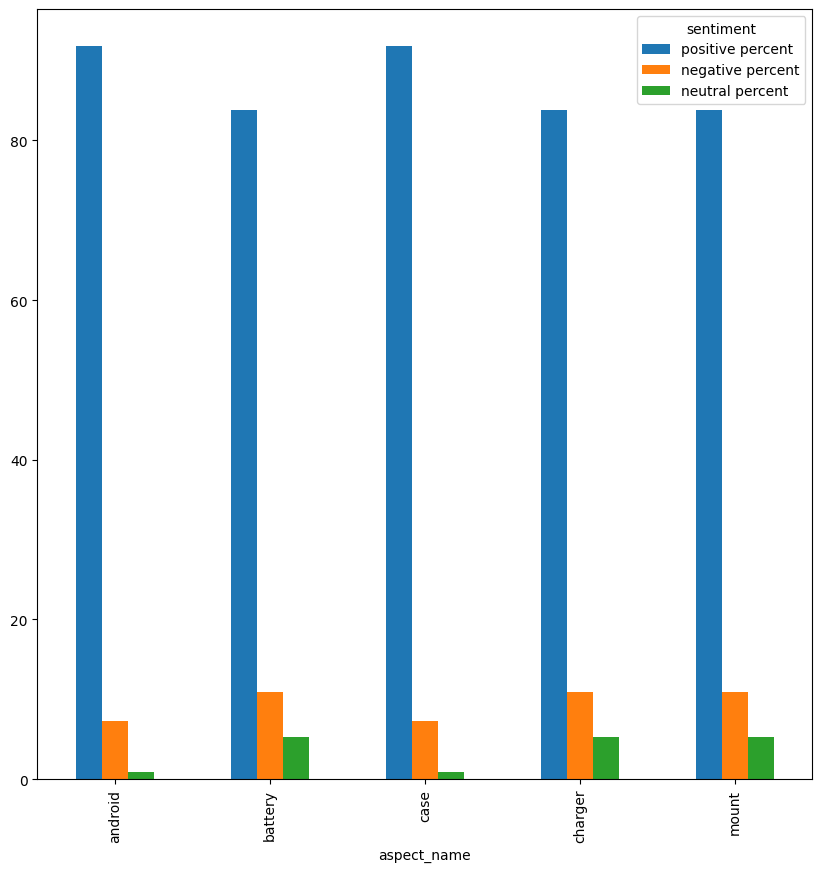

In [ ]:
fig = graph_img.plot.bar(rot=90, figsize=(10,10))
# fig.figure.savefig(img_graph_path, bbox_inches='tight')

# Wordnet

In [ ]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # return None
        return wordnet.NOUN

In [ ]:
positive_words = []
negative_words = []

for i in df_device['Dominant_topic'].unique():
    if i==1:
        tmp_1 = df_device.loc[df_device['Dominant_topic'] == i]
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if isinstance(get_pos_tag,str):
                    try:
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')
                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                    positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                    negative_words.append(p[0])     
                    except Exception as e:
                        pass

In [ ]:
print(positive_words)
print(negative_words)

['happily', 'happy', 'pleased', 'concerned', 'happy', 'happy', 'happy', 'marvel', 'happy', 'happy', 'surprise', 'surprise', 'surprise', 'happy', 'happy', 'pleased', 'pleased', 'amazing', 'happy', 'pleased', 'happy', 'pleased', 'pleased', 'happy', 'love', 'pleased', 'amazing', 'pleased', 'happy', 'marvelous', 'love', 'happy', 'pleased', 'happy', 'happy', 'love', 'wonderfully', 'amazing', 'pleased', 'happy', 'pleased', 'happy', 'happy', 'love', 'pleased', 'pleased', 'happy', 'pleased', 'pleased', 'love', 'joy', 'joy', 'happy', 'wonderful', 'wonderfully', 'wonderful']
['uncomfortable', 'cool', 'surprising', 'shame', 'fear', 'cool', 'shame', 'worry', 'pain', 'shame', 'dreadful', 'fear', 'uncomfortable', 'terrible', 'sorry', 'pain', 'hate', 'worry', 'worry', 'hate', 'cool', 'worry', 'worry', 'poorly', 'shame', 'shock', 'excited', 'awkward', 'worry', 'fear', 'sad', 'weak', 'quiet', 'worry', 'distasteful', 'spite', 'worry', 'weak', 'weak', 'weak', 'dreadful', 'malicious', 'grief', 'shock', 'd

In [ ]:
unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)

## paths for positive and negative word cloud

In [ ]:
img_pos_wordcloud_path = os.path.join(sample_img_path,"aspect1_positive_wordcloud")
img_neg_wordcloud_path = os.path.join(sample_img_path,"aspect1_negative_wordcloud")
print(img_pos_wordcloud_path)
print(img_neg_wordcloud_path)

/content/drive/MyDrive/SNA Project/sample_images_model/aspect1_positive_wordcloud
/content/drive/MyDrive/SNA Project/sample_images_model/aspect1_negative_wordcloud


## Positive word cloud

<Figure size 2000x1000 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

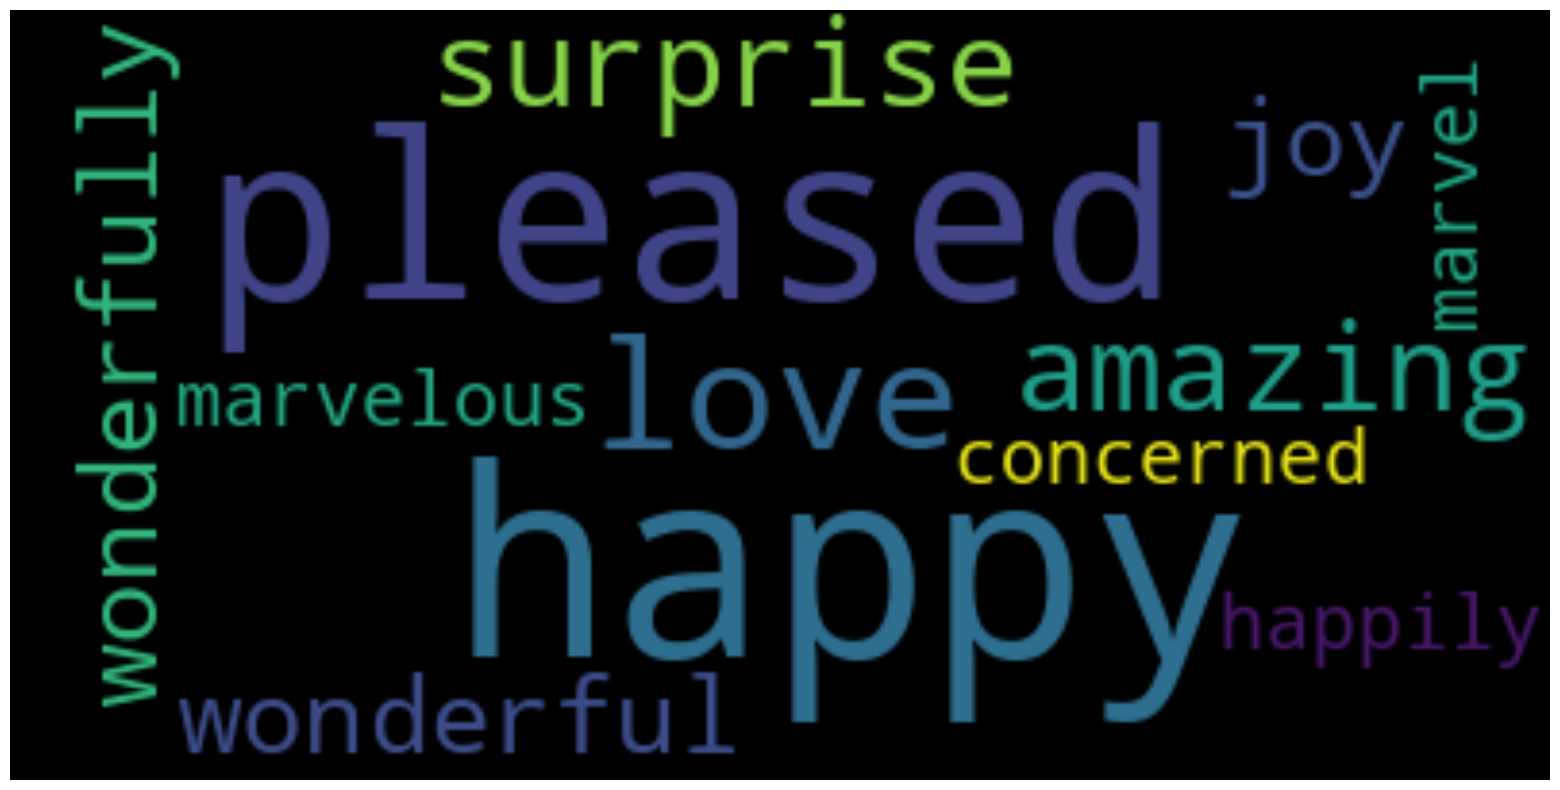

In [ ]:
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(img_pos_wordcloud_path)
plt.show()

## Negative wordcloud

<Figure size 2000x1000 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

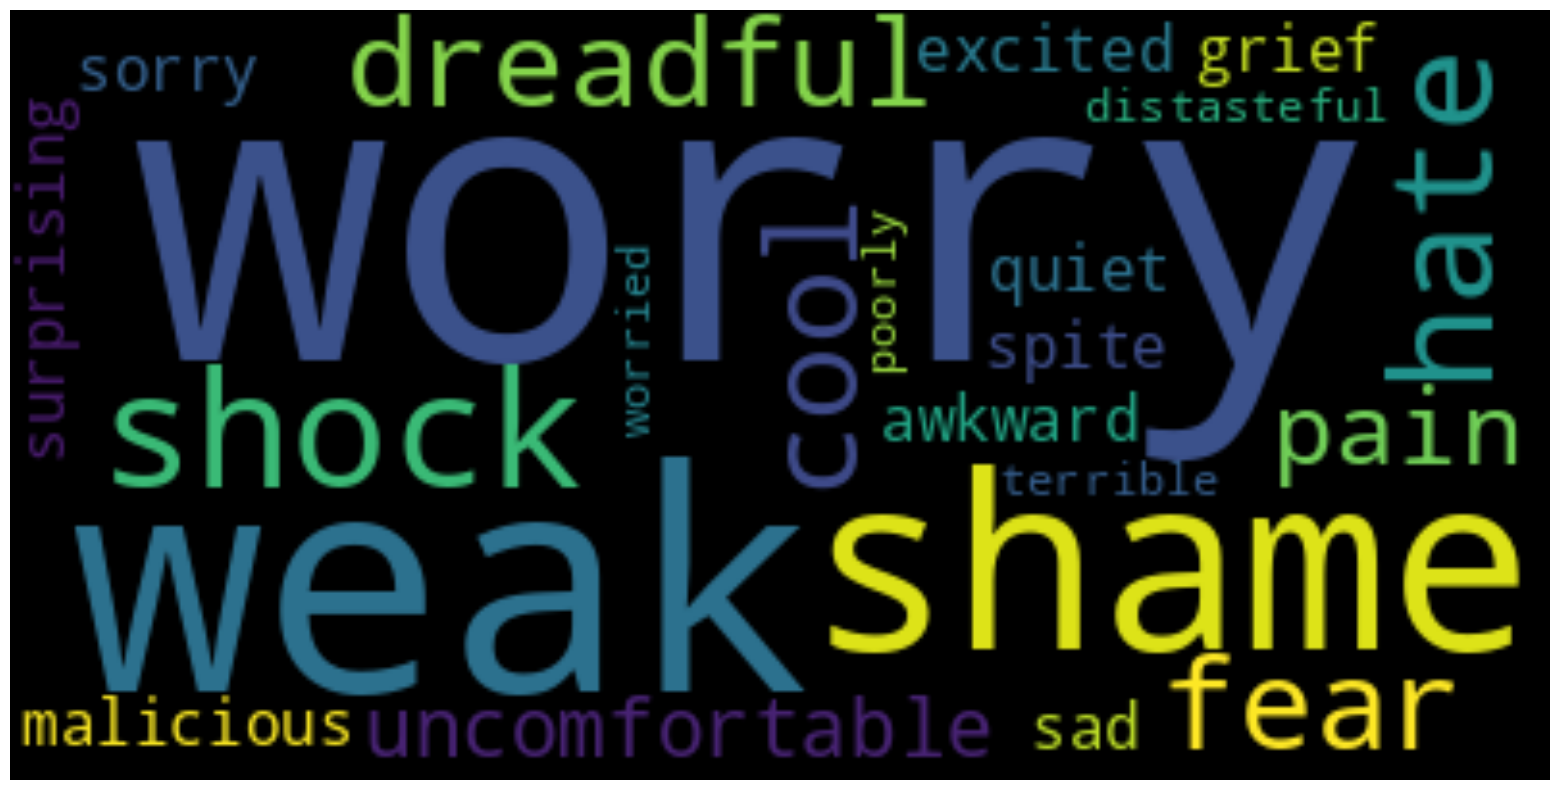

In [ ]:
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v
    
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(img_neg_wordcloud_path)
plt.show()